In [2]:
import torch
import numpy as np
from model_lstm import GridTorch
from dataloading import Dataset
import utils
import glob
import tensorflow as tf
import sonnet as snt
%pylab
%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/lucas/anaconda3/envs/diss/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/lucas/anaconda3/envs/diss/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/lucas/anaconda3/envs/diss/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [3]:
tf.enable_eager_execution()

## In this notebook we will unittest the pytorch implementation of Banino et al. (2018) in a backwards fashion, layer by layer.

In [4]:

N_EPOCHS = 1000
STEPS_PER_EPOCH = 1000
ENV_SIZE = 2.2
BATCH_SIZE = 10
GRAD_CLIPPING = 1e-5
SEED = 8341
N_PC = [256]
N_HDC = [12]
BOTTLENECK_DROPOUT = 0.5
WEIGHT_DECAY = 1e-5
LR = 1e-5
MOMENTUM = 0.9
SAVE_LOC = 'experiments/standard/'


# Create the ensembles that provide targets during training
place_cell_ensembles = utils.get_place_cell_ensembles(
        env_size=ENV_SIZE,
        neurons_seed=SEED,
        targets_type='softmax',
        lstm_init_type='softmax',
        n_pc=N_PC,
        pc_scale=[0.01])

head_direction_ensembles = utils.get_head_direction_ensembles(
        neurons_seed=SEED,
        targets_type='softmax',
        lstm_init_type='softmax',
        n_hdc=N_HDC,
        hdc_concentration=[20.])

target_ensembles = place_cell_ensembles + head_direction_ensembles

model = GridTorch(target_ensembles, (BATCH_SIZE, 100, 3), tf_weights_loc='weights/')
model = model.eval()
model

GridTorch(
  (rnn): TFLSTMCell()
  (bottleneck): Linear(in_features=128, out_features=256, bias=False)
  (pc_logits): Linear(in_features=256, out_features=256, bias=True)
  (hd_logits): Linear(in_features=256, out_features=12, bias=True)
  (state_embed): Linear(in_features=268, out_features=128, bias=True)
  (cell_embed): Linear(in_features=268, out_features=128, bias=True)
  (dropout): Dropout(p=0.5)
)

## Load unittest data

In [6]:
unittest_data_dict = {}
unittest_files = glob.glob('unittest_data/lstm/*')
for i, f in enumerate(unittest_files):
    k = f.split('.')[0].split('/')[-1]
    loaded = np.load(f)
    if not loaded.dtype == object:
        loaded = torch.Tensor(loaded)
    unittest_data_dict[k] = loaded
    
print(unittest_data_dict.keys())

dict_keys(['output_place', 'output_hd_fields', 'target_hd_fields', 'btln_60_separation', 'lstm', 'grid_cells_core_pc_logits_w:0', 'btln_90_separation', 'grid_cells_core_lstm_b_gates:0', 'initial_conds_0', 'grid_cells_core_pc_logits_b:0', 'initial_conds_1', 'bottleneck', 'grid_cells_core_bottleneck_w:0', 'grid_cell_supervised_state_init_b:0', 'state_init', 'grid_cells_core_pc_logits_1_w:0', 'init_hd', 'lstm_60', 'bottleneck_w', 'grid_cells_core_lstm_w_gates:0', 'grid_cells_core_pc_logits_1_b:0', 'btln_90', 'target_place', 'cell_init', 'grid_cell_supervised_cell_init_b:0', 'target_pos', 'grid_cell_supervised_state_init_w:0', 'lstm_90', 'grid_cell_supervised_cell_init_w:0', 'ego_vel', 'init_pos', 'target_hd', 'btln_60'])


# UNITTEST 1:
### loss

In [7]:
test_input_1 = unittest_data_dict['output_place']
test_input_2 = unittest_data_dict['target_place']

#torch loss:
logsoftmax = torch.nn.LogSoftmax(dim=-1)
def cross_entropy(pred, soft_targets):
    return torch.sum(- soft_targets * logsoftmax(pred), -1)

model_output = cross_entropy(test_input_1, test_input_2)
expected_result = tf.nn.softmax_cross_entropy_with_logits_v2(test_input_2.numpy(), test_input_1.numpy())

tf.reduce_mean(expected_result), tf.reduce_mean(model_output.numpy())

(<tf.Tensor: id=35, shape=(), dtype=float32, numpy=2.5156038>,
 <tf.Tensor: id=42, shape=(), dtype=float32, numpy=2.5156057>)

## data loading

In [8]:
from torch.utils import data
data_params = {'batch_size': 10000,
          'shuffle': True,
          'num_workers': 6, # num cpus,
          }
loader = Dataset()
dataset = Dataset(batch_size=data_params['batch_size'])
data_generator = data.DataLoader(dataset, **data_params)


In [9]:
for X, y in data_generator:
    break
    
loaded_target_pos , _ = y
loaded_init_pos, loaded_init_hd, loaded_ego_vel = X

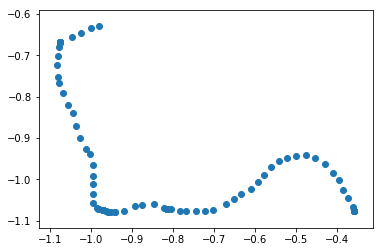

In [10]:
loaded_target_pos, _ = y
plt.scatter(loaded_target_pos.numpy()[0].T[0], loaded_target_pos.numpy()[0].T[1])

In [11]:
dic = torch.load('../data/torch/1-99.pt')
loaded_target_pos = dic['target_pos']
loaded_init_pos, loaded_init_hd, loaded_ego_vel = dic['init_pos'], dic['init_hd'], dic['ego_vel']

In [12]:
loaded_ego_vel.shape

(10000, 100, 3)

## UNITTEST 2:
### 2a): bottleneck -> HD/PC 

In [13]:
test_weights = unittest_data_dict['grid_cells_core_pc_logits_w:0']
test_biases = unittest_data_dict['grid_cells_core_pc_logits_b:0']

test_input = unittest_data_dict['bottleneck']
expected_output = unittest_data_dict['output_place']

model_output = model.pc_logits(test_input)
test_output = torch.matmul(test_input, test_weights) + test_biases

In [14]:
(model_output - test_output).max(), abs(expected_output - model_output).max()

(tensor(0., grad_fn=<MaxBackward1>), tensor(0.1172, grad_fn=<MaxBackward1>))

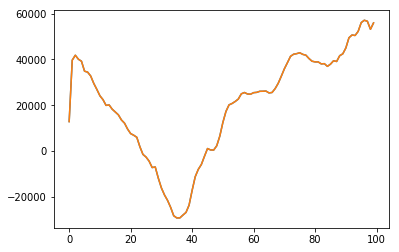

In [15]:
plt.plot(expected_output[0, :, 0].numpy())
plt.plot(model_output[0, :, 0].detach().numpy())

In [16]:
test_weights = unittest_data_dict['grid_cells_core_pc_logits_1_w:0']
test_biases = unittest_data_dict['grid_cells_core_pc_logits_1_b:0']

test_input = unittest_data_dict['bottleneck']
expected_output = unittest_data_dict['output_hd_fields']

model_output = model.hd_logits(test_input)
test_output = torch.matmul(test_input, test_weights) + test_biases

In [17]:
(model_output - test_output).max(), abs(test_output - expected_output).max()

(tensor(0., grad_fn=<MaxBackward1>), tensor(0.0156))

### 2b): lstm -> bottleneck 

In [18]:
test_weights = unittest_data_dict['bottleneck_w'][:128]

test_input = unittest_data_dict['lstm']
expected_output = unittest_data_dict['bottleneck']

model_output = model.bottleneck(test_input)
test_output = torch.matmul(test_input, test_weights) 

In [19]:
test_weights.shape

torch.Size([128, 256])

In [20]:
(model_output - test_output).max(), abs(model_output - expected_output).max()

(tensor(0., grad_fn=<MaxBackward1>), tensor(0.0007, grad_fn=<MaxBackward1>))

### 2c) input -> initial lstm conditions

In [21]:

test_input_0 = unittest_data_dict['initial_conds_0']
test_input_1 = unittest_data_dict['initial_conds_1']

test_input=torch.cat((test_input_0, test_input_1), dim=1)

test_state_weights = unittest_data_dict['grid_cell_supervised_state_init_w:0']
test_state_bias = unittest_data_dict['grid_cell_supervised_state_init_b:0']

model_state = model.state_embed(test_input)
expected_state = test_input @ test_state_weights + test_state_bias

abs(model_state - expected_state).max()

tensor(2.3842e-07, grad_fn=<MaxBackward1>)

In [22]:
test_input_0 = unittest_data_dict['initial_conds_0']
test_input_1 = unittest_data_dict['initial_conds_1']

test_input = torch.cat((test_input_0, test_input_1), dim=1)

test_state_weights = unittest_data_dict['grid_cell_supervised_cell_init_w:0']
test_state_bias = unittest_data_dict['grid_cell_supervised_cell_init_b:0']

model_state = model.cell_embed(test_input)
expected_state = test_input @ test_state_weights + test_state_bias

abs(model_state - expected_state).max()

tensor(9.5367e-07, grad_fn=<MaxBackward1>)

In [23]:
test_input_0 = unittest_data_dict['initial_conds_0']
test_input_1 = unittest_data_dict['initial_conds_1']

test_input = torch.cat((test_input_0, test_input_1), dim=1)

test_state_weights = unittest_data_dict['grid_cell_supervised_cell_init_w:0']
test_state_bias = unittest_data_dict['grid_cell_supervised_cell_init_b:0']

model_state = model.cell_embed(test_input)
expected_state = unittest_data_dict['cell_init']

In [24]:
abs(model_state - expected_state).max()

tensor(1.9073e-06, grad_fn=<MaxBackward1>)

## LSTM 

In [25]:
test_init_0 = unittest_data_dict['initial_conds_0']
test_init_1 = unittest_data_dict['initial_conds_1']
test_init = torch.cat((test_init_0, test_init_1), dim=1)

test_input = unittest_data_dict['ego_vel']

test_state_embed = model.state_embed(test_init)
test_cell_embed = model.cell_embed(test_init)

test_weights = unittest_data_dict['grid_cells_core_lstm_w_gates:0']
test_biases = unittest_data_dict['grid_cells_core_lstm_b_gates:0']

expected_output = unittest_data_dict['lstm']

lstm = model.rnn

In [26]:
test_weights.shape

torch.Size([131, 512])

In [27]:
from torch import nn
def sigmoid(x):
    return(1.0/(1.0+np.exp(-x)))
def LSTMlayer(weight,x_t,h_tm1,c_tm1):
    '''
    c_tm1 = np.array([0,0]).reshape(1,2)
    h_tm1 = np.array([0,0]).reshape(1,2)
    x_t   = np.array([1]).reshape(1,1)
    
    warr.shape = (nfeature,hunits*4)
    uarr.shape = (hunits,hunits*4)
    barr.shape = (hunits*4,)
    
    multiply = math_ops.multiply
    new_c = add(multiply(c, sigmoid(add(f, forget_bias_tensor))),
                multiply(sigmoid(i), self._activation(j)))
    new_h = multiply(self._activation(new_c), sigmoid(o))
    '''
    warr, barr = weight
    
    args = np.concatenate((x_t,h_tm1), axis=1)
    
    out = np.matmul(args, warr) + barr
    
    i, j, f, o = np.split(out, 4, 1)
    g = np.tanh(j)
    
    sigmoid_f = sigmoid(f + 1.) #forget_bias = 1
    
    c_t = c_tm1 * sigmoid_f + sigmoid(i) * g
    
    h_t = np.tanh(c_t) * sigmoid(o)
    return(h_t,c_t)

def LSTMlayer_pyt(weights,x_t, h, c):
    '''
    c_tm1 = np.array([0,0]).reshape(1,2)
    h_tm1 = np.array([0,0]).reshape(1,2)
    x_t   = np.array([1]).reshape(1,1)
    
    warr.shape = (nfeature,hunits*4)
    uarr.shape = (hunits,hunits*4)
    barr.shape = (hunits*4,)
    '''
    w, b = ws
    w, b = torch.Tensor(w), torch.Tensor(b)
    h_tm1, c_tm1 = h, c
    args = torch.cat((x_t,h_tm1), dim=1)
    out = torch.matmul(args, w) + b
    
    i, j, f, o = torch.split(out, 128, 1)

    g = torch.tanh(j)
    
    sigmoid_f = nn.functional.sigmoid(f + 1.) 
    c_t = torch.mul(c_tm1, sigmoid_f) + torch.mul(nn.functional.sigmoid(i) ,g)
    h_t = torch.mul(torch.tanh(c_t),nn.functional.sigmoid(o))
    return h_t, c_t


In [28]:
ws = test_weights.numpy(), test_biases.numpy()
s, c  = LSTMlayer(ws, test_input[0, 0][None, :].detach().numpy(), test_state_embed[0][None, :].detach().numpy(),test_cell_embed[0][None, :].detach().numpy())
s_t, c_t  = LSTMlayer_pyt(ws, test_input[0, 0][None, :], test_state_embed[0][None, :],test_cell_embed[0][None, :])

/home/lucas/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


custom function produces same output as tensorflow


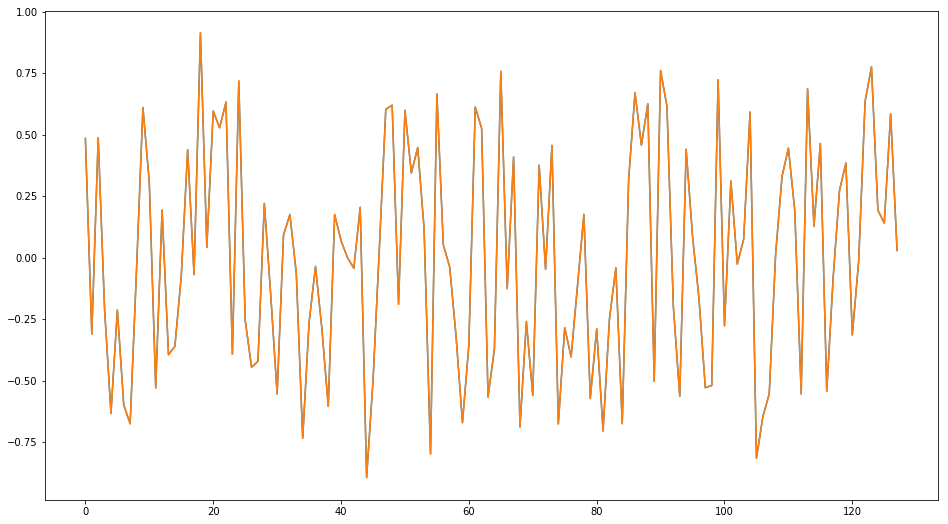

In [29]:
f = plt.figure(figsize=(16, 9))
plt.plot(s[0])
plt.plot(s_t[0].detach().numpy())
#plt.plot(expected_output[0][0].numpy())
print("custom function produces same output as tensorflow")
plt.show()

In [30]:
model_s, model_c = lstm(test_input[0, 0][None, :], (test_state_embed[0][None, :],test_cell_embed[0][None, :]))


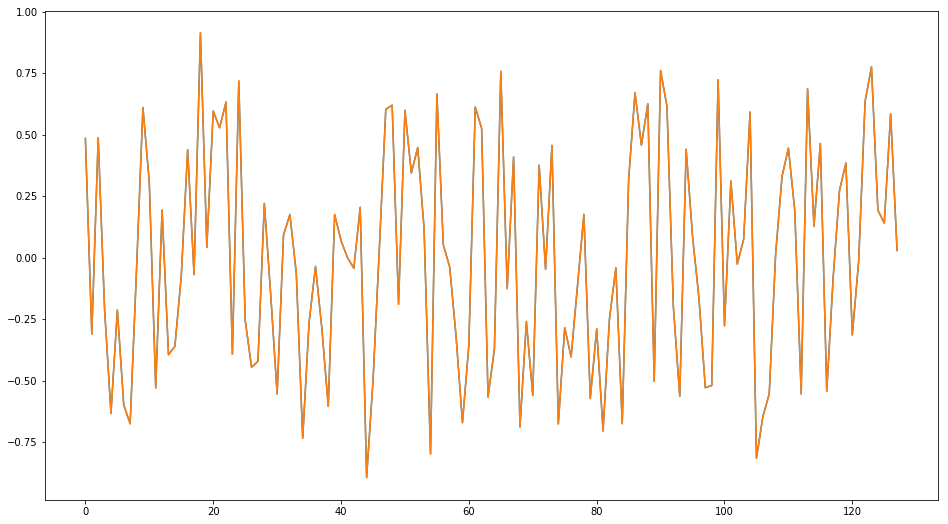

In [31]:
f = plt.figure(figsize=(16, 9))
plt.plot(model_s[0].detach().numpy())
plt.plot(s[0])


## 3) Front to end unittests
### 3a) input to bottleneck

In [32]:
init_pos = unittest_data_dict['init_pos']
init_hd = unittest_data_dict['init_hd']

init_0 = unittest_data_dict['initial_conds_0']
init_1 = unittest_data_dict['initial_conds_1']

In [35]:
# Create the ensembles that provide targets during training
%autoreload 2
place_cell_ensembles = utils.get_place_cell_ensembles(
        env_size=ENV_SIZE,
        neurons_seed=SEED,
        targets_type='softmax',
        lstm_init_type='softmax',
        n_pc=N_PC,
        pc_scale=[0.01])

head_direction_ensembles = utils.get_head_direction_ensembles(
        neurons_seed=SEED,
        targets_type='softmax',
        lstm_init_type='softmax',
        n_hdc=N_HDC,
        hdc_concentration=[20.])




initial_conds = utils.encode_initial_conditions(init_pos ,
                                                init_hd,
                                                place_cell_ensembles,
                                                head_direction_ensembles)

In [36]:
abs(initial_conds[0] - test_init_0).sum()

tensor(1974.7004)

In [39]:
expected_lstm.shape, loaded_ego_vel.shape

NameError: name 'expected_lstm' is not defined

In [38]:
results, _ = model.forward(torch.Tensor(test_input).transpose(1, 0), (test_init_0, test_init_1))
logits_hd, logits_pc, bottleneck_acts, lstm_states = results

In [ ]:
c.transpose(1, 0).shape, test_init_0.shape, torch.stack(bottleneck_acts).transpose(1, 0).shape

In [ ]:
abs(torch.stack(lstm_states).transpose(1, 0) - expected_lstm).max()

In [ ]:
abs(torch.stack(bottleneck_acts).transpose(1, 0) - expected_bottleneck).max()

In [ ]:
target_pos = unittest_data_dict['target_pos'].numpy()
target_pos.shape

In [ ]:
from scores import GridScorer

In [ ]:
# Create scorer objects
starts = [0.2] * 10
ends = np.linspace(0.4, 1.0, num=10)
masks_parameters = zip(starts, ends.tolist())
scorer = GridScorer(40, ((-1.1, 1.1), (-1.1, 1.1)),
                                    masks_parameters)

In [ ]:
loaded_target_pos.shape

In [ ]:
scoress = utils.get_scores_and_plot(scorer, target_pos, torch.stack(bottleneck_acts).transpose(1, 0).detach().numpy(), '.', 'test.pdf', plot_graphs=False)